# Data Science Challenge: Trips!

In [87]:
# load some default Python modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import xgboost as xgb
import calendar

from scipy import stats
from scipy.stats import lognorm
from math import radians, cos, sin, asin, sqrt 
from tqdm import tqdm_notebook
from pylab import rcParams

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, roc_auc_score, classification_report
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
palette = sns.color_palette('Paired', 10)
%matplotlib inline
plt.subplots_adjust(left=0.4 , bottom=0.1, right=0.9, top=2.5, wspace=1)

<Figure size 432x288 with 0 Axes>

In [0]:
# read data in pandas dataframe
df = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv')

In [4]:
# list first five rows
df.head(5)

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979485,40.684956,-73.979431,40.685020,1,...,7.8,0.0,0.0,1.95,0.0,NaN,0.0,9.75,1,2.0
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010796,40.912216,-74.010780,40.912212,1,...,45.0,0.0,0.0,0.00,0.0,NaN,0.0,45.00,1,2.0
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,...,4.0,0.5,0.5,0.50,0.0,NaN,0.3,5.80,1,1.0
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0


In [5]:
# look at the shape of data
print (df.shape)

(1494926, 21)


In [6]:
# check datatypes
df.dtypes

VendorID                   int64
lpep_pickup_datetime      object
Lpep_dropoff_datetime     object
Store_and_fwd_flag        object
RateCodeID                 int64
Pickup_longitude         float64
Pickup_latitude          float64
Dropoff_longitude        float64
Dropoff_latitude         float64
Passenger_count            int64
Trip_distance            float64
Fare_amount              float64
Extra                    float64
MTA_tax                  float64
Tip_amount               float64
Tolls_amount             float64
Ehail_fee                float64
improvement_surcharge    float64
Total_amount             float64
Payment_type               int64
Trip_type                float64
dtype: object

In [7]:
# check statistics of the features
df.describe()

,VendorID,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
count,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,0.0,1.494926e+06,1.494926e+06,1.494926e+06,1.494922e+06
mean,1.782045e+00,1.097653e+00,-7.383084e+01,4.069114e+01,-7.383728e+01,4.069291e+01,1.370598e+00,2.968141e+00,1.254320e+01,3.512800e-01,4.866408e-01,1.235727e+00,1.231047e-01,NaN,2.920991e-01,1.503215e+01,1.540559e+00,1.022353e+00
std,4.128570e-01,6.359437e-01,2.776082e+00,1.530882e+00,2.677911e+00,1.476698e+00,1.039426e+00,3.076621e+00,1.008278e+01,3.663096e-01,8.504473e-02,2.431476e+00,8.910137e-01,NaN,5.074009e-02,1.155316e+01,5.232935e-01,1.478288e-01
min,1.000000e+00,1.000000e+00,-8.331908e+01,0.000000e+00,-8.342784e+01,0.000000e+00,0.000000e+00,0.000000e+00,-4.750000e+02,-1.000000e+00,-5.000000e-01,-5.000000e+01,-1.529000e+01,NaN,-3.000000e-01,-4.750000e+02,1.000000e+00,1.000000e+00
25%,2.000000e+00,1.000000e+00,-7.395961e+01,4.069895e+01,-7.396782e+01,4.069878e+01,1.000000e+00,1.100000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,NaN,3.000000e-01,8.160000e+00,1.000000e+00,1.000000e+00
50%,2.000000e+00,1.000000e+00,-7.394536e+01,4.074674e+01,-7.394504e+01,4.074728e+01,1.000000e+00,1.980000e+00,9.500000e+00,5.000000e-01,5.000000e-01,0.000000e+00,0.000000e+00,NaN,3.000000e-01,1.176000e+01,2.000000e+00,1.000000e+00
75%,2.000000e+00,1.000000e+00,-7.391748e+01,4.080255e+01,-7.391013e+01,4.079015e+01,1.000000e+00,3.740000e+00,1.550000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,NaN,3.000000e-01,1.830000e+01,2.000000e+00,1.000000e+00
max,2.000000e+00,9.900000e+01,0.000000e+00,4.317726e+01,0.000000e+00,4.279934e+01,9.000000e+00,6.031000e+02,5.805000e+02,1.200000e+01,5.000000e-01,3.000000e+02,9.575000e+01,NaN,3.000000e-01,5.813000e+02,5.000000e+00,2.000000e+00


**Question 1:
Programmatically download and load into your favorite analytical tool the trip data for September 2015.
Report how many rows and columns of data you have loaded.**

In [8]:
# Print the size of the dataset
row_count = df.shape[0] # 0 for row
column_count = df.shape[1] # 1 for column
print("Number of rows:", row_count)
print("Number of columns:", column_count)

Number of rows: 1494926
Number of columns: 21


Which shows 1,494,926 Trips!

In [9]:
# A bit of data cleaning before moving further 
print(df.Fare_amount.min(), df.Fare_amount.max())

-475.0 580.5


The minimal fare_amount is negative. As this does not seem to be realistic, I droped them from the data.

In [10]:
print(f"There are {len(df[df['Fare_amount'] < 0])} negative fares.")
print(f"There are {len(df[df['Fare_amount'] == 0])} $0 fares.")
print(f"There are {len(df[df['Fare_amount'] > 199])} fares greater than $199.")

There are 2417 negative fares.
There are 4468 $0 fares.
There are 163 fares greater than $199.


In [11]:
print('Old size: %d' % len(df))
df = df[df.Fare_amount>=0]
print('New size: %d' % len(df))

Old size: 1494926
New size: 1492509


In [12]:
print(df.isnull().sum())

VendorID                       0
lpep_pickup_datetime           0
Lpep_dropoff_datetime          0
Store_and_fwd_flag             0
RateCodeID                     0
Pickup_longitude               0
Pickup_latitude                0
Dropoff_longitude              0
Dropoff_latitude               0
Passenger_count                0
Trip_distance                  0
Fare_amount                    0
Extra                          0
MTA_tax                        0
Tip_amount                     0
Tolls_amount                   0
Ehail_fee                1492509
improvement_surcharge          0
Total_amount                   0
Payment_type                   0
Trip_type                      4
dtype: int64


In [0]:
### will be done later ----------#########################

 Some of the minimum and maximum longitude/lattitude coordinates are way off. These I will also remove from the dataset (I will define a bounding box for the coordinates, see further).

**Question 2:
a) Plot a histogram of the number of the trip distance (“Trip Distance”).**

In [0]:
Trip_distance = df['Trip_distance']

In [15]:
Trip_distance.head(5)

0    0.00
1    0.00
2    0.59
3    0.74
4    0.61
Name: Trip_distance, dtype: float64

In [0]:
# maximum  and minimum of trip distances
max_Trip_distance = df['Trip_distance'].max() 
min_Trip_distance = df['Trip_distance'].min() 

In [17]:
print("Maximum trip distance:", max_Trip_distance, "miles")
print("Minimum trip distance:", min_Trip_distance, "miles")

Maximum trip distance: 603.1 miles
Minimum trip distance: 0.0 miles


In [18]:
 # trip distance value count
trip_distance_value_count = df['Trip_distance'].value_counts()
trip_distance_value_count.head(5)

0.0    19986
1.0    16735
0.9    16691
0.8    16142
1.1    16070
Name: Trip_distance, dtype: int64

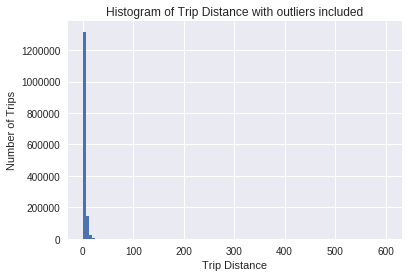

In [19]:

_ = plt.hist(df['Trip_distance'],bins=100)
_ = plt.title('Histogram of Trip Distance with outliers included')
_ = plt.xlabel('Trip Distance')
_ = plt.ylabel('Number of Trips')
plt.show()

As we can see, big chunk of trip are less than 30 miles.

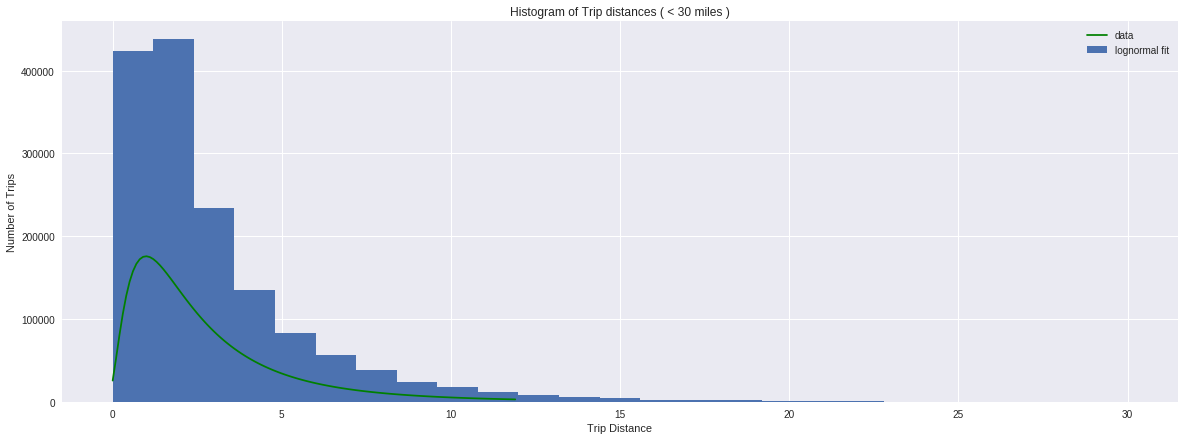

In [20]:
# We can apply a lognormal here, by using the mean of trip distance
fig,ax = plt.subplots(1,figsize = (20, 7)) 
ax.set_xlabel('Trip Distance')
ax.set_ylabel('Number of Trips')
ax.set_title('Histogram of Trip distances ( < 30 miles )')
plt.hist(df['Trip_distance'][df['Trip_distance']<30],bins = 25)
scatter,loc,mean = lognorm.fit(df.Trip_distance.values,
                               scale=df.Trip_distance.mean(),
                               loc=0)
pdf_fitted = lognorm.pdf(np.arange(0,12,.1),scatter,loc,mean)
ax.plot(np.arange(0,12,.1),600000*pdf_fitted,'g') 
ax.legend(['data','lognormal fit'])
plt.show()

 Now let's look at Trip Distance variations. 
 We will first convert datetime variables to pandas datetime series.

In [0]:
# before converting time variables, let's make a copy first
df_2=df.copy()

In [0]:
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime']) # change pickuptime to datetime 
df['Lpep_dropoff_datetime'] = pd.to_datetime(df['Lpep_dropoff_datetime'])# change drop off to datetime 
df['HourOfDay'] = df['lpep_pickup_datetime'].dt.hour # Obtain time of day variable
df['DayofWeek'] = df['lpep_pickup_datetime'].dt.dayofweek # get the day of week variable

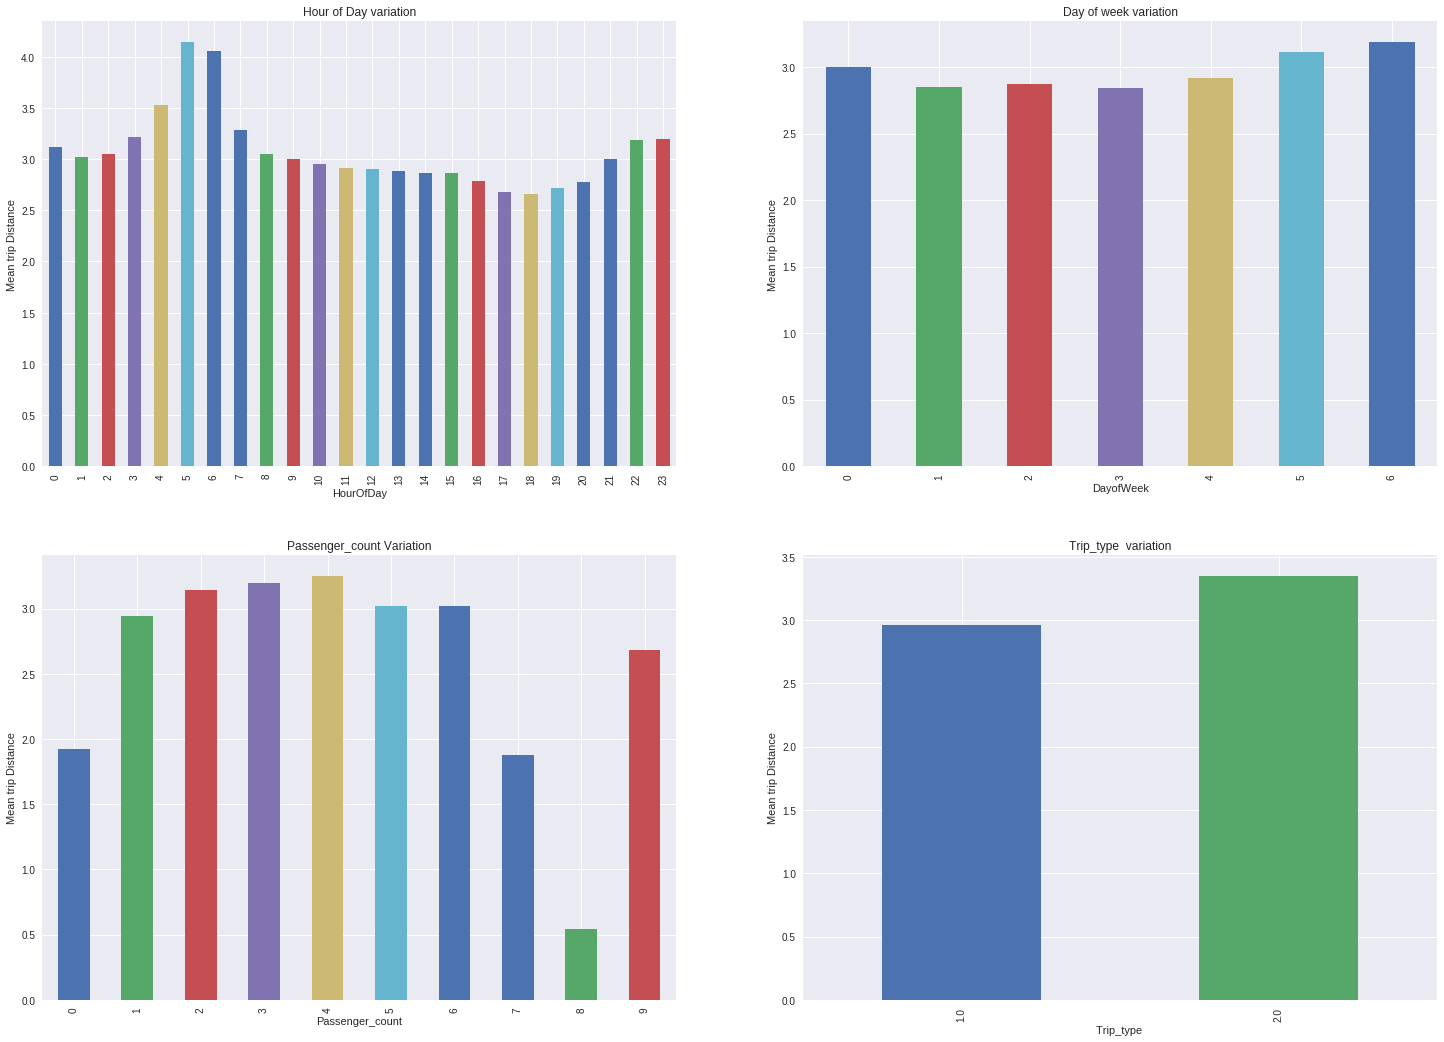

In [23]:
rcParams['figure.figsize'] = 25, 18
plt.subplot(2,2, 1)
df.groupby('HourOfDay')['Trip_distance'].mean().plot(kind='bar')
plt.title('Hour of Day variation')
plt.ylabel('Mean trip Distance')

plt.subplot(2, 2, 2)
df.groupby('DayofWeek')['Trip_distance'].mean().plot(kind='bar')
plt.title('Day of week variation')
plt.ylabel('Mean trip Distance')

plt.subplot(2,2, 3)
df.groupby('Passenger_count')['Trip_distance'].mean().plot(kind='bar')
plt.title('Passenger_count Variation')
plt.ylabel('Mean trip Distance')

plt.subplot(2, 2, 4)
df.groupby('Trip_type ')['Trip_distance'].mean().plot(kind='bar')
plt.title('Trip_type  variation')
plt.ylabel('Mean trip Distance')

plt.show()

**Question 2: b)Report any structure you find and any hypotheses you have about that structure**

Findings:
One of the features that the above histograms show us is the "shape" of the statistical data -- in other words, the manner in which the "trip distance" data falls into groups.
Shape of the above histograms: Skewed right. The histogram A is just one tall bar, whereas the histogram B is skewed right, because it looks like a lopsided mound, with a tail going off to the right. You can see on the right side there are only a fractional amount of trips when compared to the trips on the left side. Most of the trips were within the 0-5 mile range. A few trips were within the 5-10 mile range, and a handful were >10 miles.
###
Observations about mean trip distance :-
Hour of Day :- Clearly at the around 6-7 am of a given day the mean Trip distance is high and drop steadily only to pick up towards the early hours of morning.
Day of Week :- People tend to travel farther distances during weekends.
PassangerCount :- Upto 4 passengers tend to travel farther distances than 1 or 2 passengers. 
Trip type :- Passengers from a dispatch tend to travel farther than street hail calls by about 0.5 miles.

From the histogram, I found most of the data to be clustered around 0 to 4 miles. My hypothesis - most people tend to use the green taxis for short range distances as nearly 14000 passengers tend to commute within 8 miles. So, these passengers most often be rushing for work or to airports (distance between Queens and JFK, Queens and LaGuardia airport is nearly 6 miles), where the green taxis operate.

# Question 3

**a) Report mean and median trip distance grouped by hour of day.**

In [0]:
# we're stripping the hour field from the pickup_datetime field to create a new field named "pickup_hour"
#df['pickup'] = df['lpep_pickup_datetime'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
#df['pickup_hour'] = df['pickup'].apply(lambda x: x.hour) # this is a new field for holding the pickup_hour.

In [0]:
# we're stripping the hour field from the dropoff_datetime field to create a new field named "dropoff_hour"
#df['dropoff'] = df['Lpep_dropoff_datetime'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
#df['dropoff_hour'] = df['dropoff'].apply(lambda x: x.hour)# this is a new field for holding the dropoff_hour.

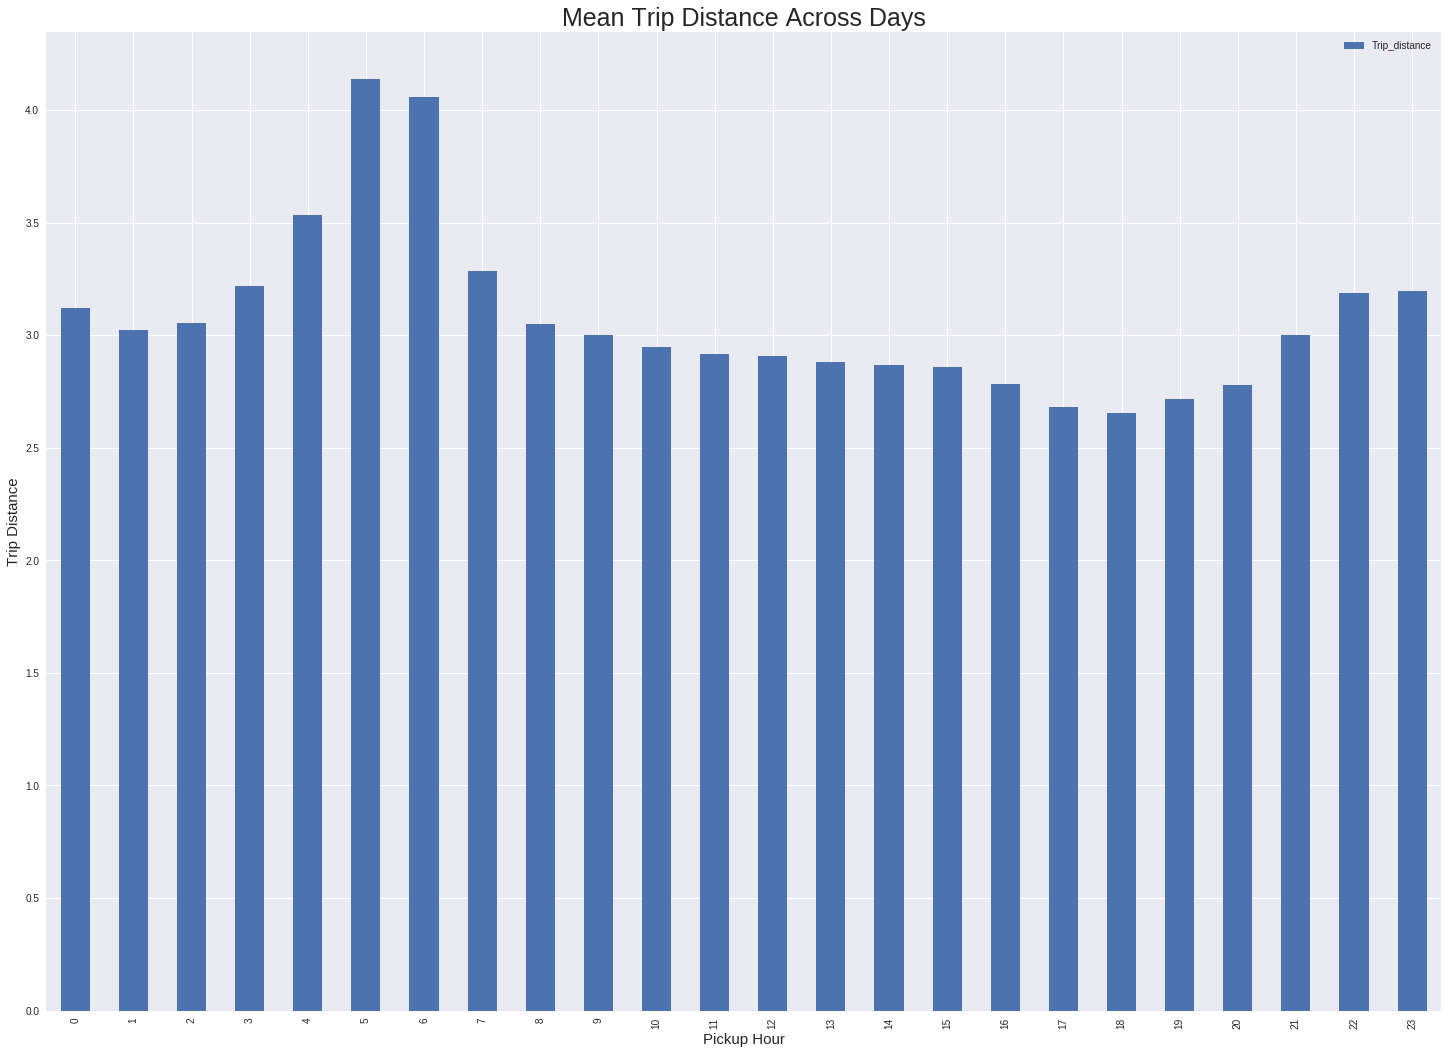

In [26]:
## change the size and color ------------------*************
_ = df[['Trip_distance','HourOfDay']].groupby('HourOfDay').mean().plot.bar()
_ = plt.title('Mean Trip Distance Across Days', fontsize = 25)
_ = plt.xlabel('Pickup Hour', fontsize = 15)
_ = plt.ylabel('Trip Distance', fontsize = 15)
plt.show()

Findings: It seems that the average trip distance for the "Green" cabs is relatively higher during the early hours( 4:00-7:00 AM).

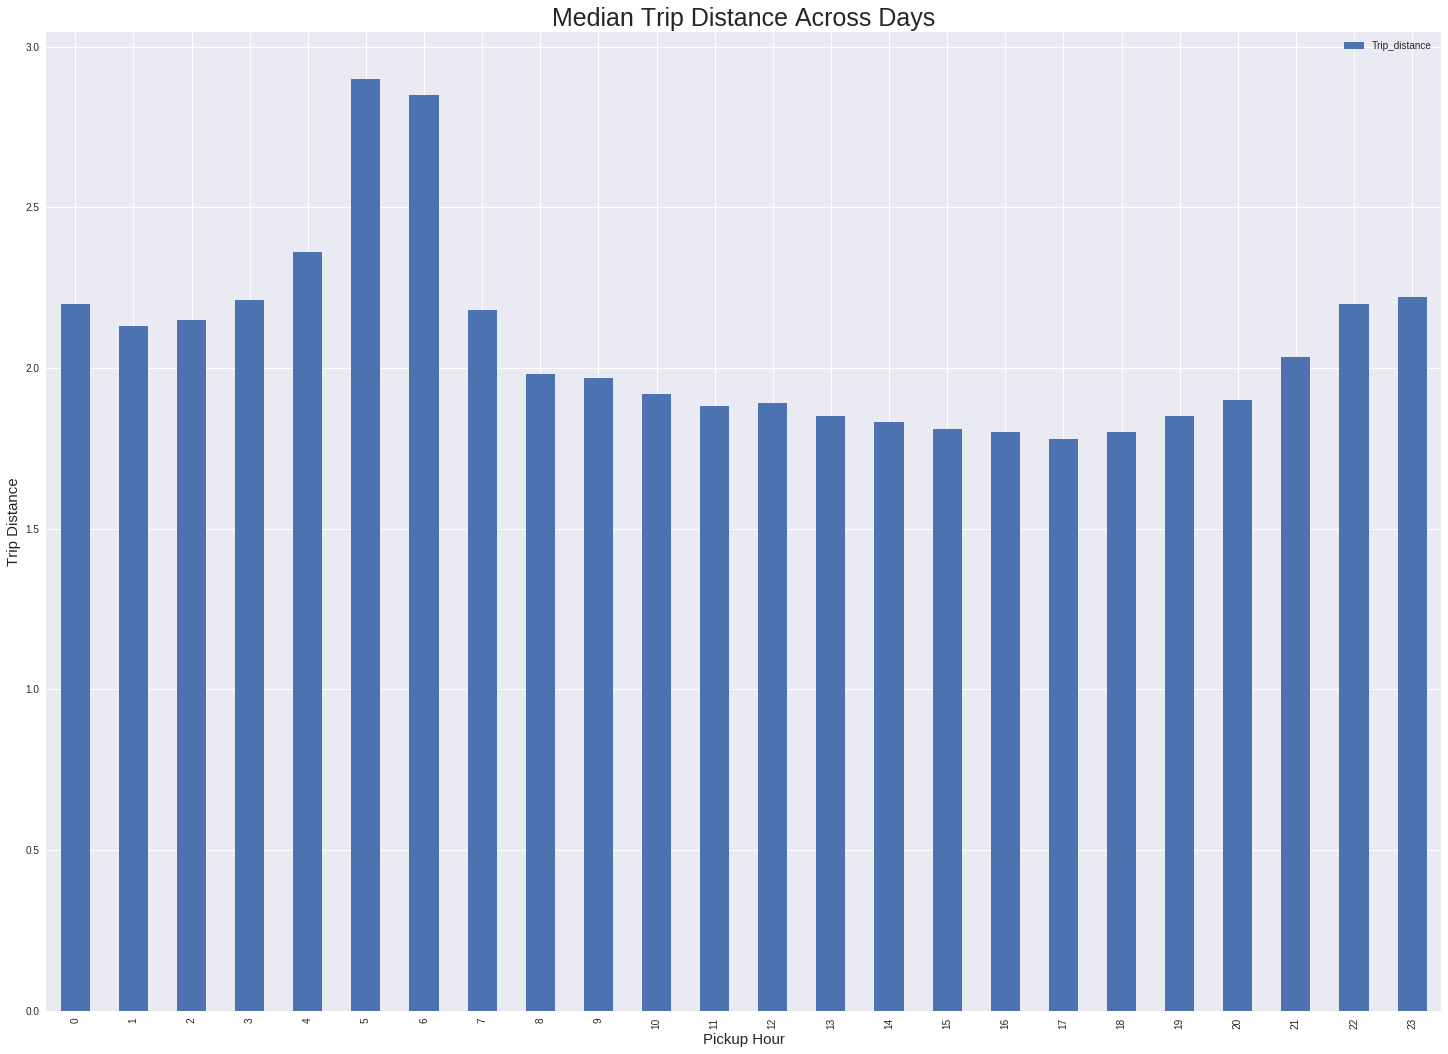

In [27]:
  _ = df[['Trip_distance','HourOfDay']].groupby('HourOfDay').median().plot.bar()
_ = plt.title('Median Trip Distance Across Days', fontsize = 25)
_ = plt.xlabel('Pickup Hour', fontsize = 15)
_ = plt.ylabel('Trip Distance', fontsize = 15)
plt.show()

Findings: Looks like the median trip distance covered by the "Green" cabs is relatively lower at midnight(0-4 AM) when compared to the trips covered immediately after the sunrise(6-8 AM)

In [0]:
df['lpep_pickup_datetime'] = pd.to_datetime(df.lpep_pickup_datetime) # convert pickup_datetime to datetime object
df.loc[:, 'day_of_week'] = df['lpep_pickup_datetime'].dt.dayofweek # extract the day of week from pickup_date

*What is the below analysis for?
Great! We've already plotted the mean/median trip distance across day, but it'd interesting to see how the trip average trip distance changes across week. So, let's go ahead and plot the data below

Line-plots
Simple lineplots can explain how the trip distance is changing with time for different days of week
pretty easy to interpret.*

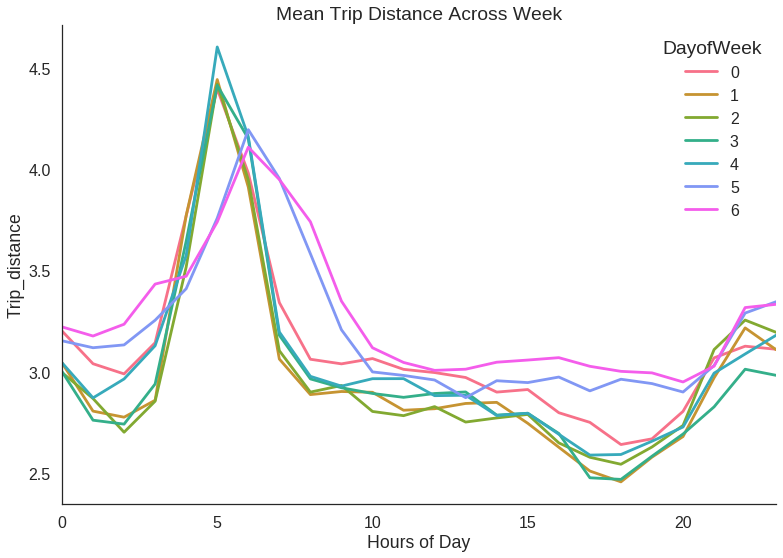

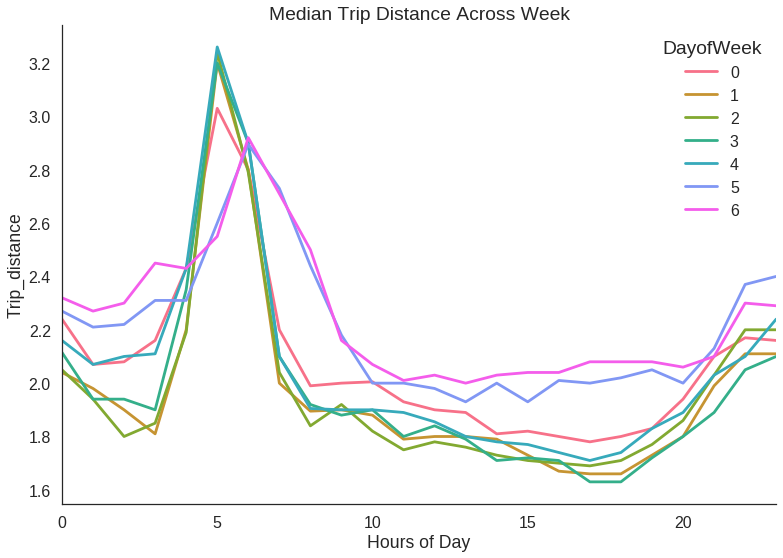

In [34]:
# code block for mean trip distance
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['DayofWeek','HourOfDay'])['Trip_distance'].mean()) 
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="HourOfDay", unit = "unit", condition="DayofWeek", value="Trip_distance")
sns.despine(bottom = False)
_ = plt.xlabel('Hours of Day')
_ = plt.title('Mean Trip Distance Across Week')
plt.show()

# code block for median trip distance
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['DayofWeek','HourOfDay'])['Trip_distance'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="HourOfDay", unit = "unit", condition="DayofWeek", value="Trip_distance")
sns.despine(bottom = False)
_ = plt.xlabel('Hours of Day')
_ = plt.title('Median Trip Distance Across Week')
plt.show()

Findings -
Its clear from the above plots that on day 1, that is Monday and day 2 that is Tuesday, the trip duration is very less than all the weekdays and weekends at 5 AM to 15 AM time. See this, on Saturday(day 6) around midnight, the rides are taking far more than usual time, this is obvious through now verified using given data

**b) We’d like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fare, and any other interesting characteristics of these trips.**

For this part we may have two different approach, one is simply by using Rate Code ID, and the other one involves some geo-analytics,
I have provided both here.

**b-1)**Easy Approach:

In [39]:
# counting the airport trips
airports_trips = df[(df.RateCodeID==2) | (df.RateCodeID==3)]
print ("Number of trips to/from NYC airports: ", airports_trips.shape[0])
print ("Average fare (calculated by the meter) of trips to/from NYC airports: $", airports_trips.Fare_amount.mean(),"per trip")
print ("Average total charged amount (before tip) of trips to/from NYC airports: $", airports_trips.Total_amount.mean(),"per trip")

Number of trips to/from NYC airports:  5390
Average fare (calculated by the meter) of trips to/from NYC airports: $ 51.67977736549165 per trip
Average total charged amount (before tip) of trips to/from NYC airports: $ 60.18036920222439 per trip


**b-2)**Complex Approach:
# Location Data Preprocessing

New York city coordinates are:

*   longitude = -74.0063889
*   lattitude = 40.7141667
So, I will plot a bounding box of interest by [long_min, long_max, latt_min, latt_max] using the minimum and maximum coordinates from the dataset. 
From Open Street Map I grab a map and I drop any datapoint outside this box.

In [40]:
# minimum and maximum longitude of dataset
min(df.Pickup_longitude.min(), df.Dropoff_longitude.min()), \
max(df.Pickup_longitude.max(), df.Dropoff_longitude.max())

(-83.27787780761719, 0.0)

In [41]:
# minimum and maximum latitude of dataset
min(df.Pickup_latitude.min(), df.Dropoff_latitude.min()), \
max(df.Pickup_latitude.max(), df.Dropoff_latitude.max())

(0.0, 43.177261352539055)

In [0]:
# this function will remove the data outside of NYC lat long
def select_within_boundingbox(df, BB):
    return (df.Pickup_longitude >= BB[0]) & (df.Pickup_longitude <= BB[1]) & \
           (df.Pickup_latitude >= BB[2]) & (df.Pickup_latitude <= BB[3]) & \
           (df.Dropoff_longitude >= BB[0]) & (df.Dropoff_longitude <= BB[1]) & \
           (df.Dropoff_latitude >= BB[2]) & (df.Dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [43]:
print('Old size: %d' % len(df))
df = df[select_within_boundingbox(df, BB)]
print('New size: %d' % len(df))

Old size: 1487767
New size: 1484512


In [0]:
# this function will be used  to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.Pickup_longitude, df.Pickup_latitude, zorder=1, alpha=alpha, c='#2e91be', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.Dropoff_longitude, df.Dropoff_latitude, zorder=1, alpha=alpha, c='#d46f9f', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

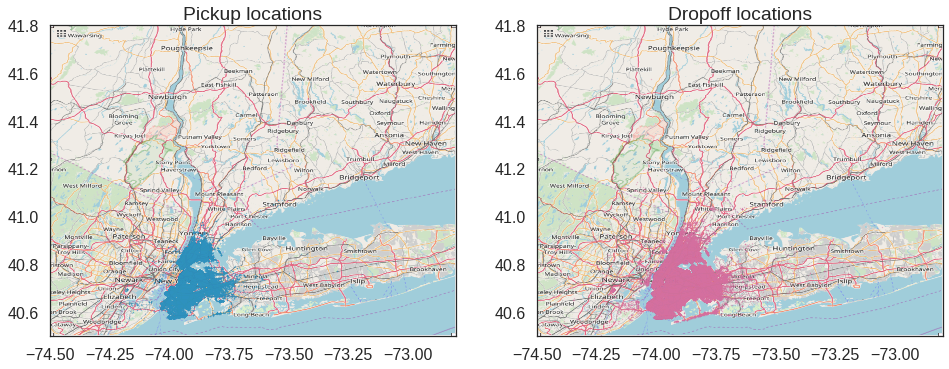

In [45]:
# plot the data on map
plot_on_map(df, BB, nyc_map, s=1, alpha=0.3)

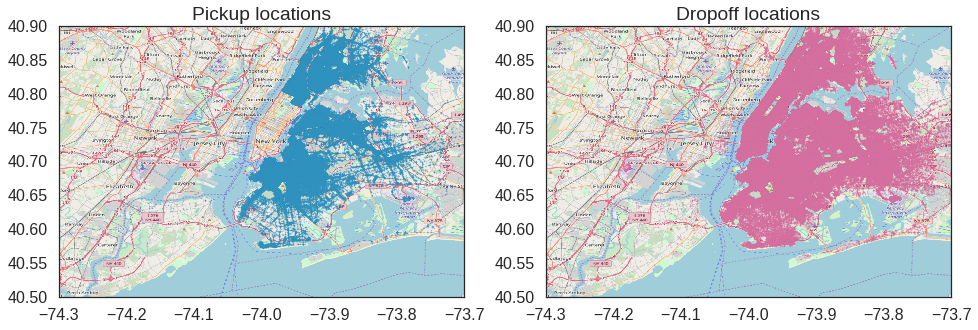

In [46]:
# plot data on map zoomed in
plot_on_map(df, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

In [0]:
# For this plot, we will need a function to calculate the distance between locations in latitude & longitude coordinates.
# This function is based on https://stackoverflow.com/questions/27928/
# Notes:
# Multiplied by 0.621371 to convert to miles in the returned result
# R = 6371 km ,Mean radius of Earth in Km

def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Math: PI / 180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) 
  
# First calculate two arrays with datapoint density per sq mile
n_lon, n_lat = 200, 200 # number of grid bins per longitude, latitude dimension
density_pickup, density_dropoff = np.zeros((n_lat, n_lon)), np.zeros((n_lat, n_lon)) # prepare arrays

# To calculate the number of datapoints in a grid area, the numpy.digitize() function is used. 
# This function needs an array with the (location) bins for counting the number of datapoints per bin.
bins_lon = np.zeros(n_lon+1) # bin
bins_lat = np.zeros(n_lat+1) # bin
delta_lon = (BB[1]-BB[0]) / n_lon # bin longutide width
delta_lat = (BB[3]-BB[2]) / n_lat # bin latitude height
bin_width_miles = distance(BB[2], BB[1], BB[2], BB[0]) / n_lon # bin width in miles
bin_height_miles = distance(BB[3], BB[0], BB[2], BB[0]) / n_lat # bin height in miles
for i in range(n_lon+1):
    bins_lon[i] = BB[0] + i * delta_lon
for j in range(n_lat+1):
    bins_lat[j] = BB[2] + j * delta_lat
    
# Digitize per longitude, latitude dimension
inds_pickup_lon = np.digitize(df.Pickup_longitude, bins_lon)
inds_pickup_lat = np.digitize(df.Pickup_latitude, bins_lat)
inds_dropoff_lon = np.digitize(df.Dropoff_longitude, bins_lon)
inds_dropoff_lat = np.digitize(df.Dropoff_latitude, bins_lat)

# Count per grid bin
# note: as the density_pickup will be displayed as image, the first index is the y-direction, 
#       the second index is the x-direction. Also, the y-direction needs to be reversed for
#       properly displaying (therefore the (n_lat-j) term)
dxdy = bin_width_miles * bin_height_miles
for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

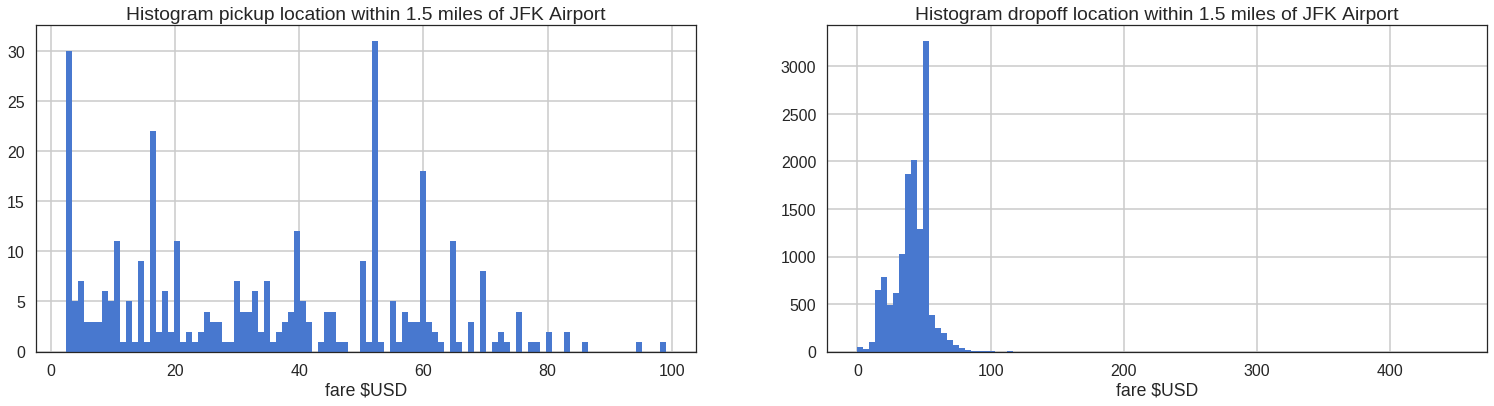

In [48]:
# This function will identify if the pickup-dropoff was in an airport.
# JFK, EWR and LGA airport coordinates, from https://www.travelmath.com/airport/
# I will do the JFK first and then the other airports.
# JFK, John F. Kennedy International Airport
# EWR, Newark Liberty International Airport
# LGA, LaGuardia Airport

JFK = (-73.7822222222, 40.6441666667)
nyc = (-74.0063889, 40.7141667)

def plot_location_fare(loc, name, range=1.5, color='cornflowerblue'):
    # select all datapoints with dropoff location within range of airport
    fig, axs = plt.subplots(1, 2, figsize=(26, 6))
    idx = (distance(df.Pickup_latitude, df.Pickup_longitude, loc[1], loc[0]) < range)
    df[idx].Fare_amount.hist(bins=100, ax=axs[0])
    axs[0].set_xlabel('fare $USD')
    axs[0].set_title('Histogram pickup location within {} miles of {}'.format(range, name))

    idx = (distance(df.Dropoff_latitude, df.Dropoff_longitude, loc[1], loc[0]) < range)
    df[idx].Fare_amount.hist(bins=100, ax=axs[1])
    axs[1].set_xlabel('fare $USD')
    axs[1].set_title('Histogram dropoff location within {} miles of {}'.format(range, name));
  
plot_location_fare(JFK, 'JFK Airport')  

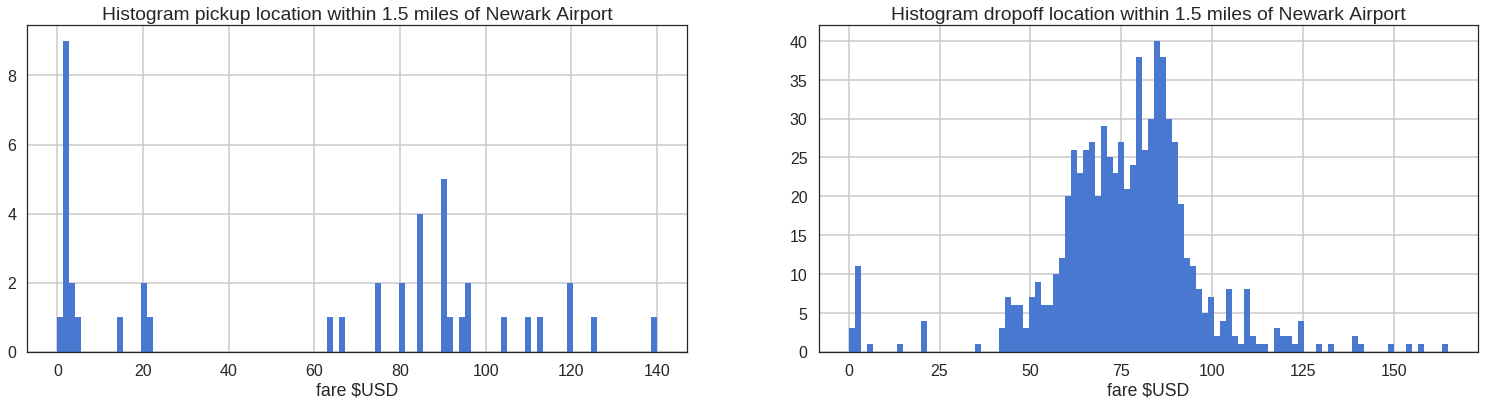

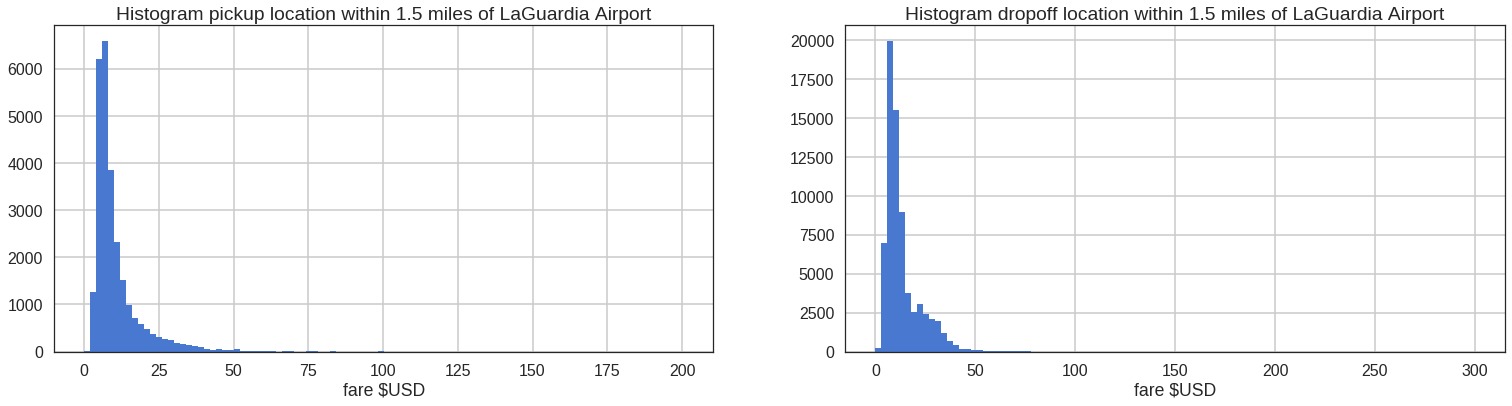

In [49]:

EWR = (-74.175, 40.69) # Newark Liberty International Airport
LGA = (-73.87, 40.77) # LaGuardia Airport, 
plot_location_fare(EWR, 'Newark Airport')
plot_location_fare(LGA, 'LaGuardia Airport')

In [0]:
# this a helper function to identify whether or not the pickup/dropoff took place at an airport.
def NYC_Airports(row):
    if (
        ((row['Pickup_longitude'] < -73.750296) & (row['Pickup_longitude'] > -73.821884) & 
       (row['Pickup_latitude'] < 40.666467) & (row['Pickup_latitude']>40.646677)) |  
        (
       (row['Dropoff_longitude'] < -73.750296) & (row['Dropoff_longitude'] > -73.821884) &
       (row['Dropoff_latitude'] < 40.666467) & (row['Dropoff_latitude']>40.646677)) ):
        
        return 'JFK' # John F. Kennedy International Airport
    
    if (
        ((row['Pickup_longitude'] < -73.865387) & (row['Pickup_longitude'] > -73.884547) & 
       (row['Pickup_latitude'] < 40.773098) & (row['Pickup_latitude']>40.767550)) | 
        (
       (row['Dropoff_longitude'] < -73.865387) & (row['Dropoff_longitude'] > -73.884547) &
       (row['Dropoff_latitude'] < 40.773098) & (row['Dropoff_latitude']>40.767550)) ):
        
        return 'LGA' # LaGuardia Airport
     
    if (
        ((row['Pickup_longitude'] <-74.15898 ) & (row['Pickup_longitude'] > -74.189765) & 
       (row['Pickup_latitude'] < 40.712632) & (row['Pickup_latitude']>40.686247)) | 
        (
       (row['Dropoff_longitude'] <-74.16898 ) & (row['Dropoff_longitude'] >  -74.187765) &
       (row['Dropoff_latitude'] < 40.712632) & (row['Dropoff_latitude']>40.676247)) ):
        
        return 'EWR' # Newark Airport 
      
    else:
        return 'NOT an Airpot Trip' # Not an Airport pickup/dropoff

In [0]:
df['Airport'] = df.apply (NYC_Airports, axis=1)

In [52]:
df['Airport'].value_counts() # what's the distribution of the rides. 

NOT an Airpot Trip    1473940
LGA                      5184
JFK                      4672
EWR                       716
Name: Airport, dtype: int64

In [53]:
print('Average fair for an airport trip : {:0.2f}'.format(df[df['Airport']!= 'NOT an Airpot Trip']['Fare_amount'].mean()))
print('number of trips satisfying the criteria:',df[df['Airport']!='NOT an Airpot Trip']['Fare_amount'].shape[0])
print('Average fair for a non-airport trip : {:0.2f}'.format(df[df['Airport']=='NOT an Airpot Trip']['Fare_amount'].mean()))

Average fair for an airport trip : 30.04
number of trips satisfying the criteria: 10572
Average fair for a non-airport trip : 12.49


## will be edited later----------------------------------?????????????????
Based on the graphs above, we can see that

Passengers tend to travel to and from LaGuardia using green taxis as they are closer to the NYC boroughs and have a shorter travel distance as well. Passengers using JFK and Newark have a high travel distance and lesser count, comparatively.

Trips distances to and from airports tend to be around 20 miles (with a minimum of 12 miles from NYC to LaGuardia and a maximum of 20 miles from NYC to Newark), while trips not originating or terminating at airports cover shorter distances with most travels within 5 miles.

The distribution for the pick-up hour is nearly the same for airport and non-airport pick-ups, with airport pick-up hour peaking at 03:00 PM and non-airport pick-ups peaking at around 07:00 PM. I can hypothesise that passengers commuting within city, tend to take taxis when they need late night travel and commuters to airports (based on the http://www.businessinsider.com/heres-why-new-york-city-air-traffic-is-so-congested-2015-7 report) like to travel from early hours to mid-day, this trend can be found in the graphs.

The distribution of trip duration shows how travelling in the city for shorter distances takes shorter time (with most data points around 0 to 20 mins) and the airport trips last longer (with most data points around 50 mins). The longer travel distance for Airport area can be credit to the tourists, most of whom on a tight schedule would want to cover attractions or have a stop-over at friends before their destination, or a passenger opting for a round-about trip while dropping off or picking up their friends or relatives at airports.

# Question 4
**Build a derived variable for tip as a percentage of the total fare.**

Before we proceed, some cleaning is reuqired. Since the initial charge for NYC green taxi is $2.5, any transaction with a smaller total amount is invalid, so I'll drop them.

In [35]:
df = df[(df.Total_amount>=2.5)] 
df['Tip_percentage'] = 100*df.Tip_amount/df.Total_amount
print ("Summary: Tip percentage\n",df.Tip_percentage.describe())

Summary: Tip percentage
 count    1.487767e+06
mean     6.665932e+00
std      8.875835e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e+01
max      1.000000e+02
Name: Tip_percentage, dtype: float64


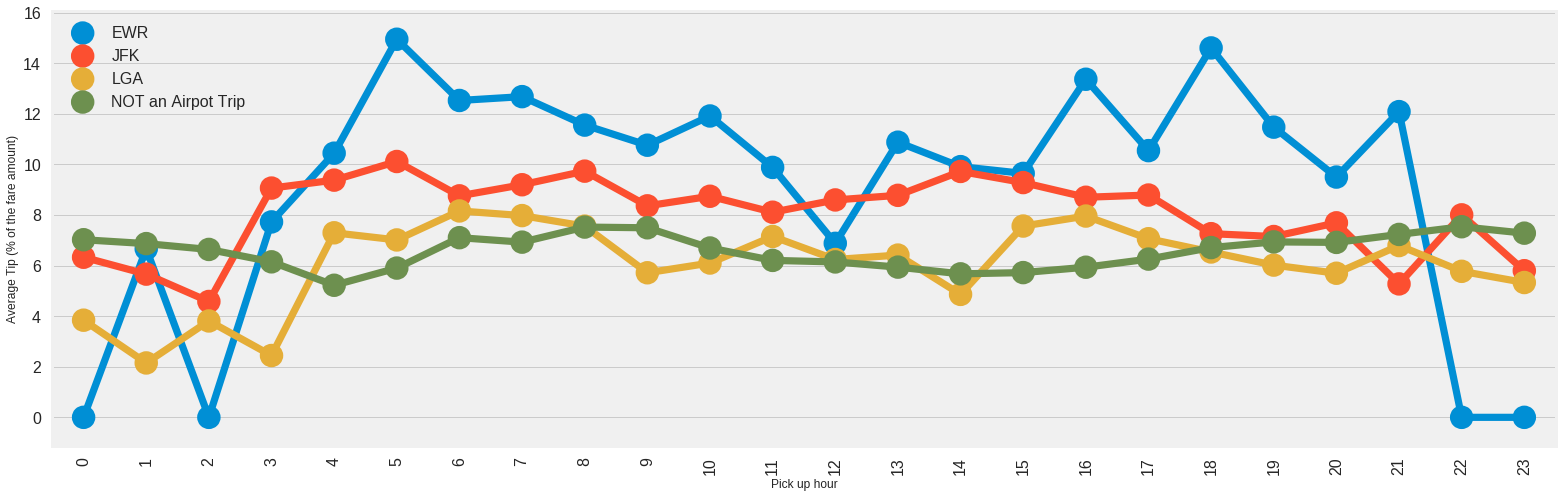

In [69]:
grouped_df = df.groupby(['HourOfDay', 'Airport'])['Tip_percentage'].aggregate(np.mean).reset_index() #average tip
plt.figure(figsize=(24,8))
sns.pointplot(grouped_df.HourOfDay.values, grouped_df.Tip_percentage.values, grouped_df.Airport.values, alpha=0.6)
plt.ylabel('Average Tip (% of the fare amount)')
plt.xlabel('Pick up hour')
plt.xticks(rotation='vertical')
plt.show()

In [0]:
### build extra airpoty distribution later -----------!!!!!!!!!!!!!!!!!!

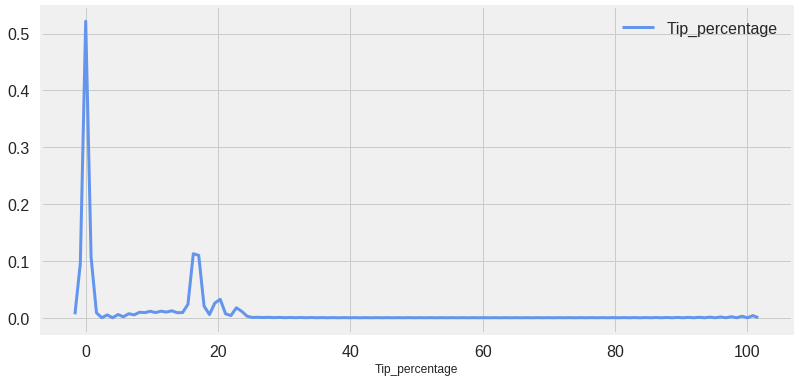

In [70]:
sns.set_color_codes()
rcParams['figure.figsize'] = 12, 6
sns.distplot(df['Tip_percentage'], hist=False,
             kde_kws={"color": "cornflowerblue", "lw": 3,
                      "label": "Tip_percentage",
                     'alpha':1.0})

**Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). Provide an estimate of performance using an appropriate sample, and show your work.**

The initial dataset contained 1494926 transactions with 21 time-series, categorical and numerical variables. In order to build the final model, four phases were followed (1) data cleaning, (2) feature engineering (3) exploratory data analysis and (4) model creation

**1) data cleaning**

In [0]:
# removing the airport class
#df=df.drop('Airport' ,axis = 1)

In [0]:
# Here, we will define a function to clean the data before buidling model

def clean_data(data_set):
    """
    This function will clean the input data_set:
    . drop Ehail_fee [99% transactions are NaNs]
    . impute missing values in Trip_type
    . replace invalid data by most frequent value for RateCodeID and Extra
    . encode categorical to numeric
    . rename pickup and dropff time variables (for later use)

    """
    # making a copy of the input
    data = df.copy()
    # drop Ehail_fee: most its values are NaNs
    if 'Ehail_fee' in data.columns:
        data.drop('Ehail_fee',axis=1,inplace=True)

    # replace missing values in Trip_type with the most frequent value 1
    data['Trip_type '] = data['Trip_type '].replace(np.NaN,1)
    
    ## replace all values that are not allowed as per the variable dictionary with the most frequent allowable value
    # remove negative values from Total amound and Fare_amount
    print ("Negative values found and replaced by their abs")
    print ("Total_amount", 100*data[data.Total_amount<0].shape[0]/float(data.shape[0]),"%")
    print ("Fare_amount", 100*data[data.Fare_amount<0].shape[0]/float(data.shape[0]),"%")
    print ("Improvement_surcharge", 100*data[data.improvement_surcharge<0].shape[0]/float(data.shape[0]),"%")
    print ("Tip_amount", 100*data[data.Tip_amount<0].shape[0]/float(data.shape[0]),"%")
    print ("Tolls_amount", 100*data[data.Tolls_amount<0].shape[0]/float(data.shape[0]),"%")
    print ("MTA_tax", 100*data[data.MTA_tax<0].shape[0]/float(data.shape[0]),"%")
    data.Total_amount = data.Total_amount.abs()
    data.Fare_amount = data.Fare_amount.abs()
    data.improvement_surcharge = data.improvement_surcharge.abs()
    data.Tip_amount = data.Tip_amount.abs()
    data.Tolls_amount = data.Tolls_amount.abs()
    data.MTA_tax = data.MTA_tax.abs()
    
    # RateCodeID
    indices_oi = data[~((data.RateCodeID>=1) & (data.RateCodeID<=6))].index
    data.loc[indices_oi, 'RateCodeID'] = 2 # 2 = Cash payment was identified as the common method
    print (round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in RateCodeID were invalid.--> Replaced by the most frequent 2")
    
    # Extra
    indices_oi = data[~((data.Extra==0) | (data.Extra==0.5) | (data.Extra==1))].index
    data.loc[indices_oi, 'Extra'] = 0 # 0 was identified as the most frequent value
    print (round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in Extra were invalid.--> Replaced by the most frequent 0")
    
    # Total_amount: the minimum charge is $2.5, so I will replace every thing less than 2.5 by the median 1.76
    indices_oi = data[(data.Total_amount<2.5)].index
    data.loc[indices_oi,'Total_amount'] = 1.76
    print (round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in total amount worth <$2.5.--> Replaced by the median 1.76")
    
    # encode categorical to numeric (I avoid to use dummy to keep dataset small)
    if data.Store_and_fwd_flag.dtype.name != 'int64':
        data['Store_and_fwd_flag'] = (data.Store_and_fwd_flag=='Y')*1
    
    return data

In [72]:
# Run code to clean the data
df = clean_data(df)

Negative values found and replaced by their abs
Total_amount 0.0 %
Fare_amount 0.0 %
Improvement_surcharge 0.0 %
Tip_amount 0.0 %
Tolls_amount 0.0 %
MTA_tax 0.0 %
0.0 % of values in RateCodeID were invalid.--> Replaced by the most frequent 2
0.0 % of values in Extra were invalid.--> Replaced by the most frequent 0
0.0 % of values in total amount worth <$2.5.--> Replaced by the median 1.76


**2 Feature engineering**

**3 Exploratory Data Analysis**

This was the key phase of my analysis. A look at the distribution of the target variable, "Tip_percentage" showed that 60% of all transactions did not give tip (see Figure below, left). A second tip at 18% corresponds to the usual NYC customary gratuity rate which fluctuates between 18% and 25% (see Figure below,right). Based on this information, the model can be built in two steps

Create classification model to predict weither tip will be given or not. Here a new variable "With_tip" of 1 (if there is tip) and 0 (otherwise) was created.
Create regression model for transaction with non-zero tip

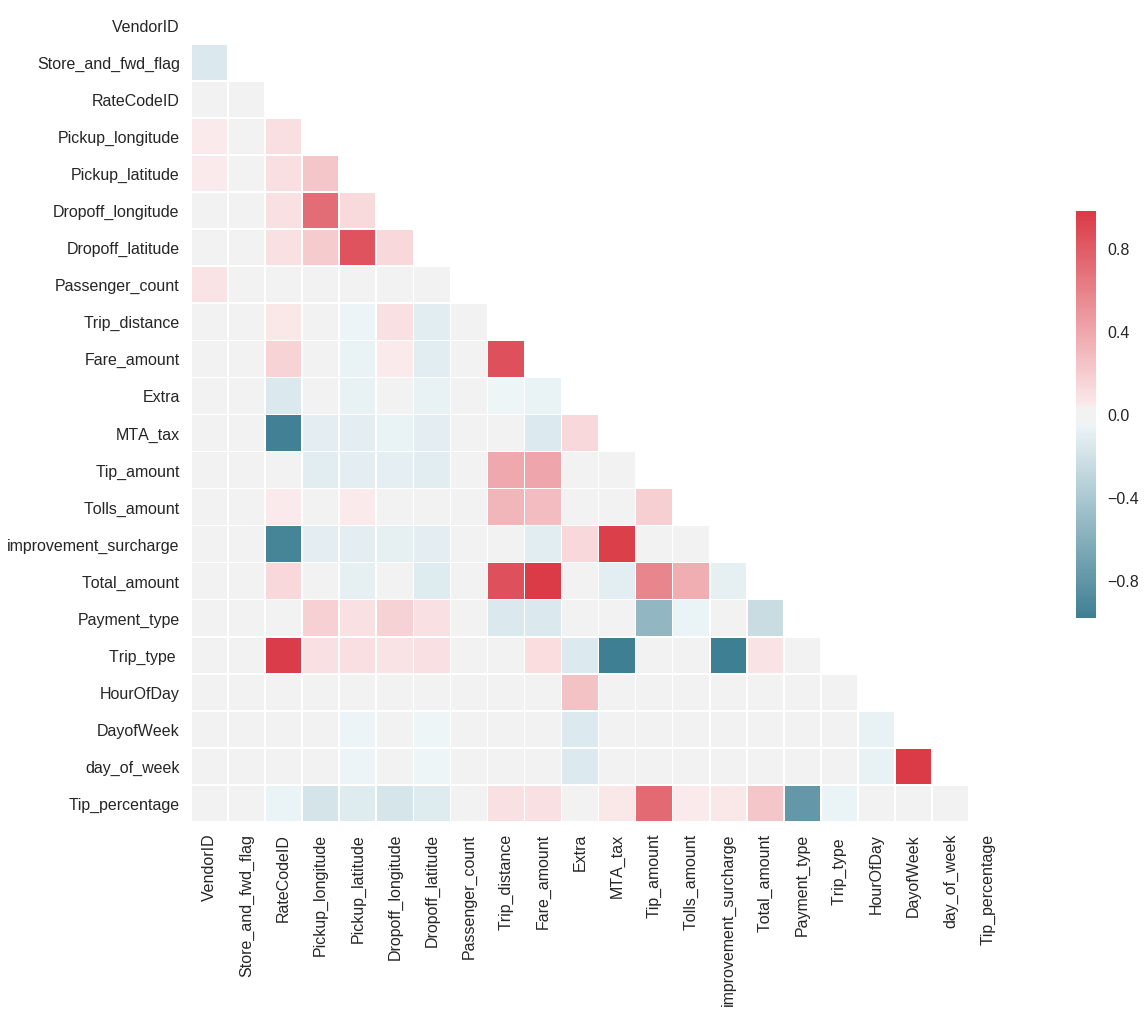

In [56]:
# Compute the correlation matrix
corr = df.corr() # corr calculation

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

A  correlation heatmap to find which independent variables are correlated to each other.

In [0]:
df['Trip_duration'] =  (df['Lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).astype('timedelta64[s]')
Trips_With_Tip = df[df.Tip_percentage>0] # rides with tips
vars_of_interest=['Total_amount','Tip_percentage','Fare_amount','Airport','Trip_distance','Trip_duration','Tolls_amount', 'Payment_type', 'Trip_type ']

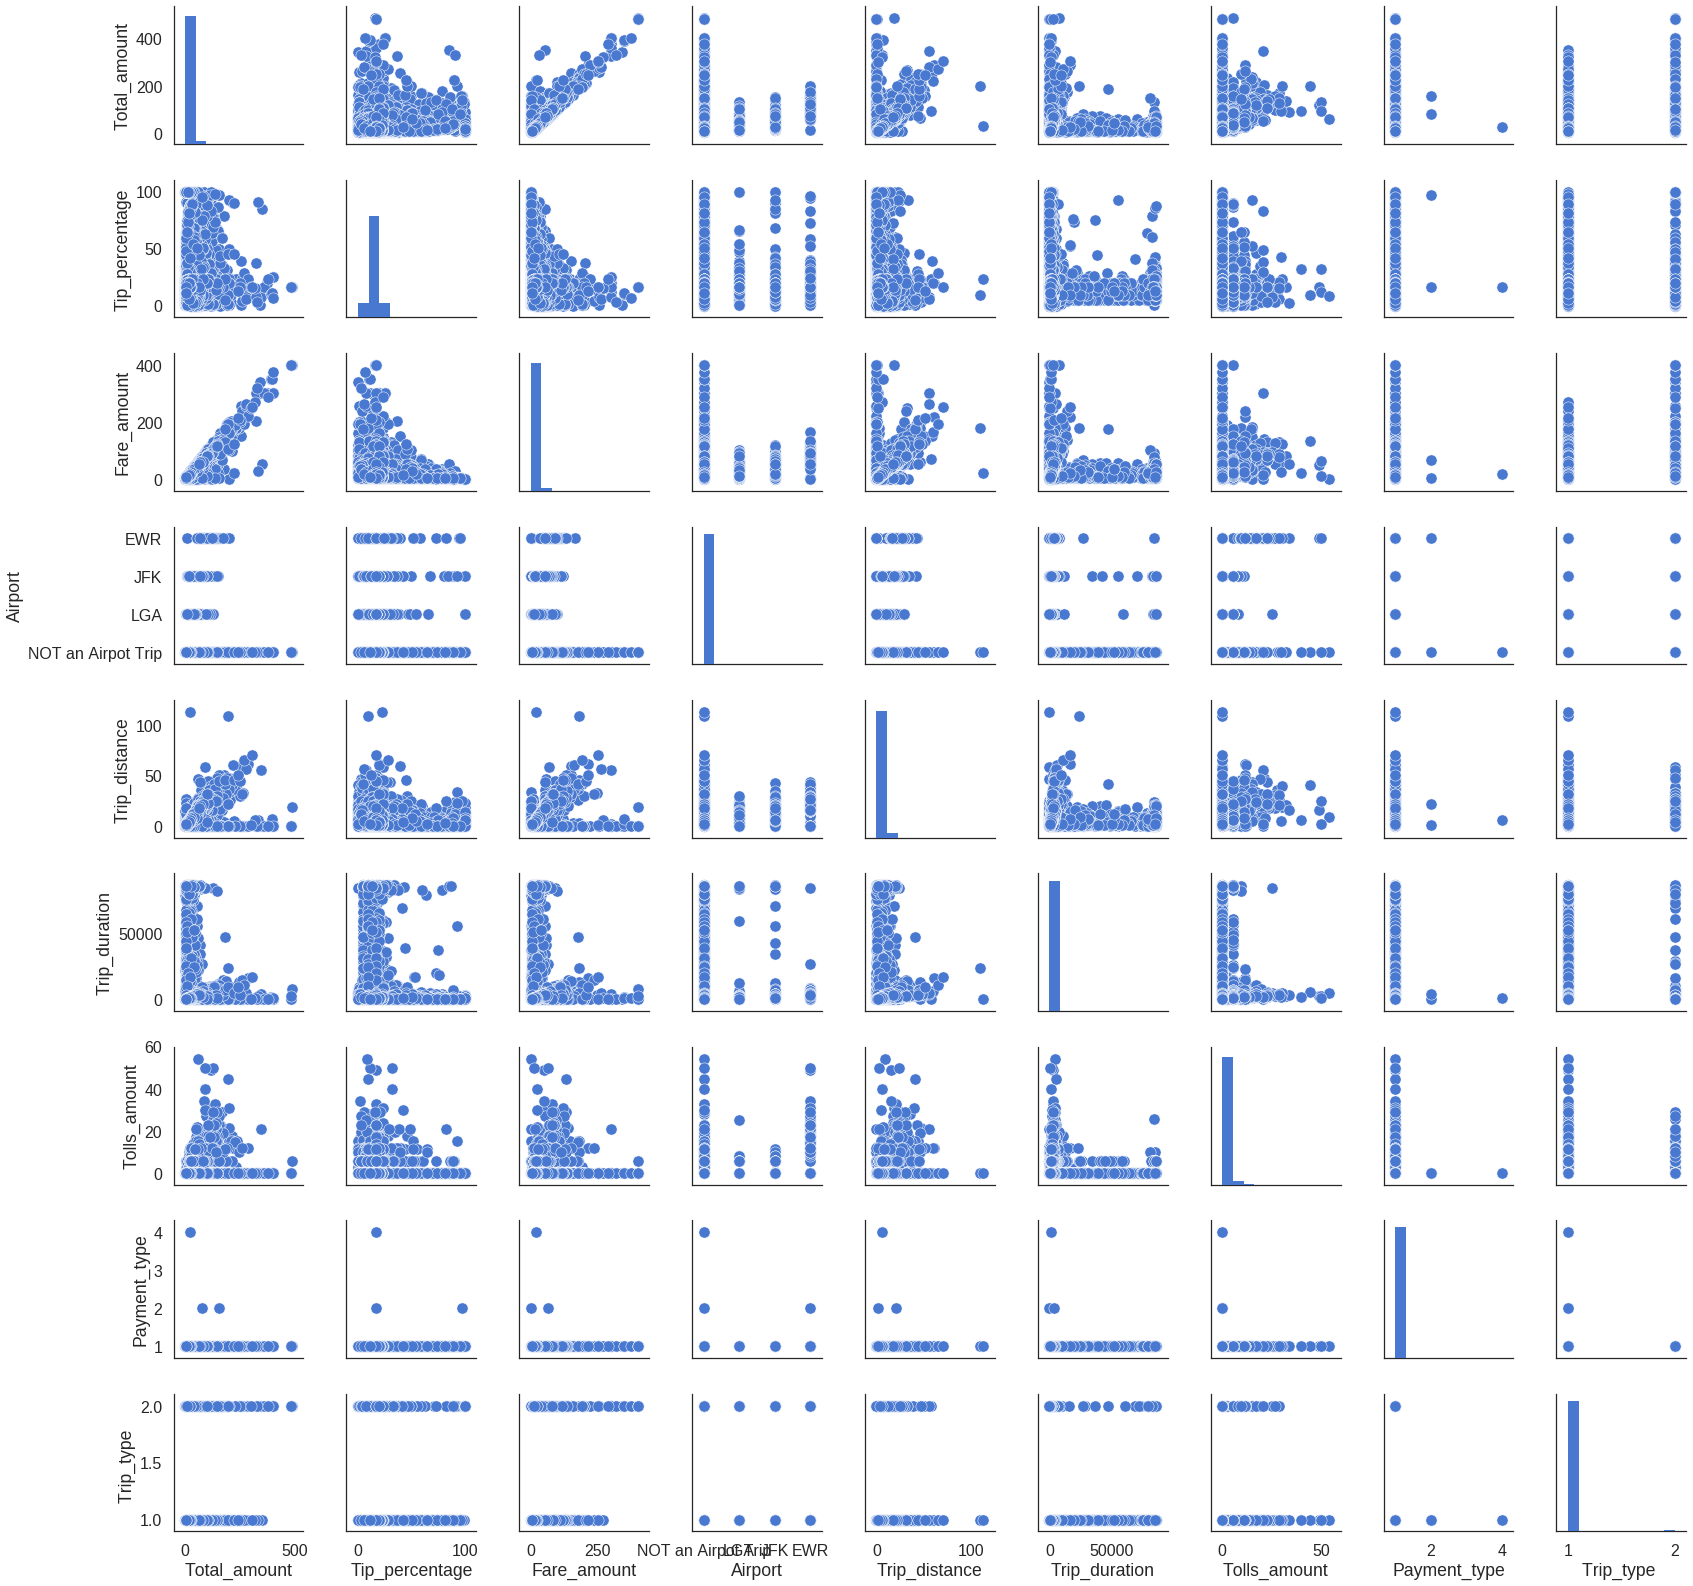

In [58]:
# Visualize pairwise relationships between quantitative features 
sns.pairplot(Trips_With_Tip[vars_of_interest], 
             vars =vars_of_interest )

As part of feature engineering, the below fields are derived:

trip_duration - difference of drop-off and pick-up times in minutes

dayOfWeek - of the trip

dayOfMonth - of the trip

hour - of the trip

speed - of the trip in miles per hour

The below filters are applied on derived variables:

Trips longer than 200 minutes are discarded as these may be tourist trips, out of city trips which can be considered as outliers

The maximum speed limit in New York City is 50 mph and in United States is 137 mph. Trips with Speed more than 140 miles per hour are discarded as this can be attributed to a faulty device or incorrect calibration, and the sample size is small.

Another interesting figure is that of the Payment_type.############################$$$$$$$$$$$$$$$$$$$$$

**4 Building the Model**

In [73]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
Lpep_dropoff_datetime    datetime64[ns]
Store_and_fwd_flag                int64
RateCodeID                        int64
Pickup_longitude                float64
Pickup_latitude                 float64
Dropoff_longitude               float64
Dropoff_latitude                float64
Passenger_count                   int64
Trip_distance                   float64
Fare_amount                     float64
Extra                           float64
MTA_tax                         float64
Tip_amount                      float64
Tolls_amount                    float64
improvement_surcharge           float64
Total_amount                    float64
Payment_type                      int64
Trip_type                       float64
HourOfDay                         int64
DayofWeek                         int64
day_of_week                       int64
Tip_percentage                  float64
Airport                          object


In [60]:
df.isnull().sum()

VendorID                 0
lpep_pickup_datetime     0
Lpep_dropoff_datetime    0
Store_and_fwd_flag       0
RateCodeID               0
Pickup_longitude         0
Pickup_latitude          0
Dropoff_longitude        0
Dropoff_latitude         0
Passenger_count          0
Trip_distance            0
Fare_amount              0
Extra                    0
MTA_tax                  0
Tip_amount               0
Tolls_amount             0
improvement_surcharge    0
Total_amount             0
Payment_type             0
Trip_type                0
HourOfDay                0
DayofWeek                0
day_of_week              0
Tip_percentage           0
Airport                  0
Trip_duration            0
dtype: int64

In [74]:
X = pd.DataFrame()
X = df[['Total_amount','Tip_percentage','Fare_amount','Airport','Trip_distance','Trip_duration','Tolls_amount', 'Payment_type', 'Trip_type ']]
X.head(5)

,Total_amount,Tip_percentage,Fare_amount,Airport,Trip_distance,Trip_duration,Tolls_amount,Payment_type,Trip_type
0,9.75,20.00000,7.8,NOT an Airpot Trip,0.00,4.0,0.0,1,2.0
1,45.00,0.00000,45.0,NOT an Airpot Trip,0.00,4.0,0.0,1,2.0
2,5.80,8.62069,4.0,NOT an Airpot Trip,0.59,154.0,0.0,1,1.0
3,6.30,0.00000,5.0,NOT an Airpot Trip,0.74,246.0,0.0,2,1.0
4,6.30,0.00000,5.0,NOT an Airpot Trip,0.61,246.0,0.0,2,1.0


In [0]:
# Encode all non-numerical variables
le = preprocessing.LabelEncoder()
X['Airport'] = le.fit_transform(X['Airport'])

In [76]:
X['Airport'].unique()

array([3, 1, 2, 0])

In [0]:
# Methodology
def performance_metric(y_true, y_predict):
    score = roc_auc_score(y_true, y_predict)  
    return score                                      

In [0]:
y = X.Tip_percentage # tip_percent is our target variable
X = X.drop('Tip_percentage', axis = 1)

In [0]:
# Split the data into test and train:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [80]:
print ("X_train.shape", X_train.shape)
print ("X_test.shape", X_test.shape)

X_train.shape (1113384, 8)
X_test.shape (371128, 8)


**First Model: Linear Regression**

In [0]:
#Y_perc = X['Tip_as_perc'] #drop outcome percentage of tip perentage from feature vector
#Y_log = X['Tip_given'] #drop outcome tip given from feature vector
#X = X.drop(['Tip_as_perc'], axis = 1)
#X = X.drop(['Tip_given'], axis = 1)


In [0]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.fit_transform(X_test)

In [83]:
linearmodel = RandomForestRegressor(100)# instantiate a Random forest regressor object
linearmodel.fit(X_train ,y_train) #initialize the object with the data

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [95]:
print("Mean squared error : %f" %metrics.mean_squared_error(y_test,linearmodel.predict(X_test)))
print("Rsquared score : %f" %metrics.r2_score(y_test,linearmodel.predict(X_test)))

Mean squared error : 3.764050
Rsquared score : 0.952218


In [123]:
print( linearmodel.feature_importances_)

[2.35596200e-01 1.04089006e-01 3.41959372e-05 6.65849612e-03
 8.59710562e-03 5.48985869e-03 6.34697747e-01 4.83739140e-03]


ValueError: ignored

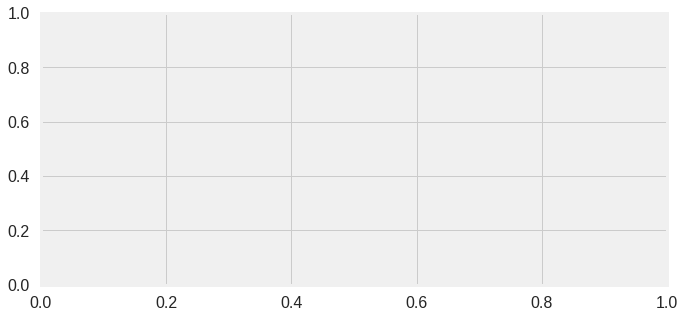

In [130]:
rcParams['figure.figsize'] = 10, 5
labels = ['Total_amount','Fare_amount','Airport','Trip_distance','Trip_type',\
          'Trip_duration']
x = [1,2,3,4,5,6]
y = linearmodel.feature_importances_
plt.bar(x, y, align = 'center')
plt.xticks(x, labels)
print('Plot feature importances...')
plt.show()


In [131]:
# Benchmark
lm = LogisticRegression()

# Train the model
lm.fit(X_train, y_train)

ValueError: ignored

In [0]:
print (performance_metric(y_train, lm.predict(X_train)))
print (performance_metric(y_test, lm.predict(X_test)))

In [0]:
clf_A = KNeighborsClassifier()
clf_B = SVC(random_state=1)
clf_C = RandomForestClassifier(random_state=1)

In [133]:
for clf in [clf_A, clf_B, clf_C]:
    print ("\n{}: \n".format(clf.__class__.__name__))
    clf.fit(X_train, y_train)
    y_predict1 = clf.predict(X_train)
    y_predict = clf.predict(X_test)
    print (performance_metric(y_train, y_predict1), performance_metric(y_test, y_predict))


KNeighborsClassifier: 



ValueError: ignored

In [134]:
clf = RandomForestClassifier(max_features=10, max_depth=8, n_estimators=100, random_state=1)
clf = clf.fit(X_train, y_train)
y_train_predict = clf.predict(X_train)
y_predict = clf.predict(X_test)


ValueError: ignored

In [0]:

print ("Tuned model has a training AUROC score of {:.4f}.".format(performance_metric(y_train, y_train_predict)))
print ("Tuned model has a testing AUROC score of {:.4f}.".format(performance_metric(y_test, y_predict)))

In [0]:
# Model Evaluation and Validation
def plt_max_features(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.3, random_state = 1)

    # Vary the max_depth parameter from 1 to 10
    features_range = np.arange(1,12)

    # Create a Random Forest classifier at optimal settings
    clf = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=1)
  
    # Calculate the training and testing scores
    train_scores, test_scores = curves.validation_curve(clf, X, y, \
        param_name = "max_features", param_range = features_range, cv = cv, scoring = 'roc_auc')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Random Forest Classifier Complexity Performance')
    plt.plot(features_range, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(features_range, test_mean, 'o-', color = 'g', label = 'Testing Score')
    plt.fill_between(features_range, train_mean - train_std, train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(features_range, test_mean - test_std, test_mean + test_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Features')
    plt.ylabel('AUROC Score')
    plt.ylim([0.83,0.88])
    plt.show()

def plt_max_depth(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.3, random_state = 1)

    # Vary the max_depth parameter from 1 to 10
    depth_range = np.arange(1,11)

    # Create a Random Forest classifier at optimal settings
    clf = RandomForestClassifier(max_features=10, n_estimators=100, random_state=1)
  
    # Calculate the training and testing scores
    train_scores, test_scores = curves.validation_curve(clf, X, y, \
        param_name = "max_depth", param_range = depth_range, cv = cv, scoring = 'roc_auc')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Random Forest Classifier Complexity Performance')
    plt.plot(depth_range, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(depth_range, test_mean, 'o-', color = 'g', label = 'Testing Score')
    plt.fill_between(depth_range, train_mean - train_std, train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(depth_range, test_mean - test_std, test_mean + test_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Depth')
    plt.ylabel('AUROC Score')
    plt.ylim([0.60,0.95])
    plt.show()

In [136]:
plt_max_features(X_train, y_train)

TypeError: ignored

In [0]:
plt_max_depth(X_train, y_train)

In [0]:
clf = RandomForestClassifier(max_features=4, max_depth=9, n_estimators=100, random_state=1)
clf = clf.fit(X_train, y_train)
y_train_predict = clf.predict(X_train)
y_predict = clf.predict(X_test)

print ("Tuned model has a training AUROC score of {:.4f}.".format(performance_metric(y_train, y_train_predict)))
print ("Tuned model has a testing AUROC score of {:.4f}.".format(performance_metric(y_test, y_predict)))

In [0]:
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

roc_auc = roc_auc_score(y_test, y_predict)  

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [0]:
#  Conclusion

In [0]:
import xgboost as xgb # please install xgboost before running this script.
import lightgbm as lgb # please install lightgbm before running this script.

In [0]:
df_model = df.reset_index() # reset the index of our dataframe. 

In [0]:
df_model = df_model.rename(columns={'index': 'ID', 'lpep_pickup_datetime': 'pickup_datetime', 'Lpep_dropoff_datetime': 'dropoff_datetime'})

In [0]:
df_model.drop(['Airport', 'RateCodeID', 'Extra'], axis=1, inplace=True) #drop these features, because they're either all 0's or Nan's

In [0]:
df_model['tip_percent'] = df_model['Tip_amount']/df_model['Total_amount'] # calculate the tip percent
df_model['tip_percent'] = df_model['tip_percent'].apply(lambda x: x * 100) # multiply the value by 100
df_model = df_model[df_model['Tip_amount'] > 0] # make sure the tip is greater than zero
df_model = df_model[df_model['Fare_amount'] > 0]

In [0]:
y = df_model.tip_percent # tip_percent is our target variable
X = df_model # predictor varibles

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2) 

In [0]:
X_test = X_test.iloc[:, :-1] # exclude the target variable(tip_percent) from our test data

In [0]:
X_test.drop(['Tip_amount'], axis=1, inplace=True) 

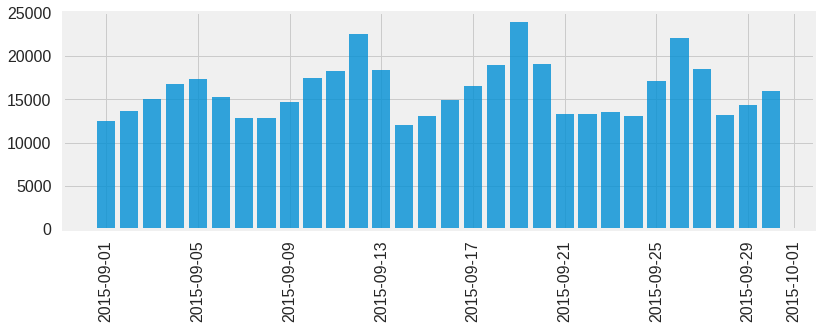

In [187]:
X_train['pickup_date'] = X_train['pickup_datetime'].dt.date
X_test['pickup_date'] = X_test['pickup_datetime'].dt.date

cnt_srs = X_train['pickup_date'].value_counts() # train pickup date
plt.figure(figsize=(12,4))
ax = plt.subplot(111)
ax.bar(cnt_srs.index, cnt_srs.values, alpha=0.8)
ax.xaxis_date()
plt.xticks(rotation='vertical')
plt.show()

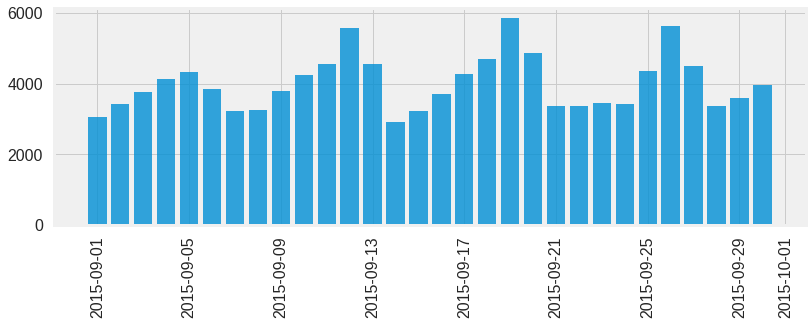

In [188]:
cnt_srs = X_test['pickup_date'].value_counts() # test pickup date
plt.figure(figsize=(12,4))
ax = plt.subplot(111)
ax.bar(cnt_srs.index, cnt_srs.values, alpha=0.8)
ax.xaxis_date()
plt.xticks(rotation='vertical')
plt.show()

In [0]:
# day of the month 
X_train['pickup_day'] = X_train['pickup_datetime'].dt.day
X_test['pickup_day'] = X_test['pickup_datetime'].dt.day

# month of the year 
X_train['pickup_month'] = X_train['pickup_datetime'].dt.month
X_test['pickup_month'] = X_test['pickup_datetime'].dt.month

# hour of the day 
X_train['pickup_hour'] = X_train['pickup_datetime'].dt.hour
X_test['pickup_hour'] = X_test['pickup_datetime'].dt.hour

# Week of year 
X_train["week_of_year"] = X_train["pickup_datetime"].dt.weekofyear
X_test["week_of_year"] = X_test["pickup_datetime"].dt.weekofyear

# Day of week 
X_train["day_of_week"] = X_train["pickup_datetime"].dt.weekday
X_test["day_of_week"] = X_test["pickup_datetime"].dt.weekday

# Convert to numeric 
map_dict = {'N':0, 'Y':1}
X_train['Store_and_fwd_flag'] = X_train['Store_and_fwd_flag'].map(map_dict)
X_test['Store_and_fwd_flag'] = X_test['Store_and_fwd_flag'].map(map_dict)

In [0]:
# logarithm of the tip_percent, because we use RMSLE
X_train['log_tip_percent'] = np.log1p(X_train['tip_percent'].values)

In [0]:
# drop off the variables which are not needed 
cols_to_drop = ['ID', 'pickup_datetime', 'pickup_date', 'dropoff_datetime']
train_id = X_train['ID'].values
test_id = X_test['ID'].values
train_y = X_train.log_tip_percent.values
train_X = X_train.drop(cols_to_drop + ['Tip_amount', 'tip_percent', 'log_tip_percent'], axis=1)
test_X = X_test.drop(cols_to_drop, axis=1)

In [0]:
def runXGB(train_X, train_y, val_X, val_y, test_X, eta=0.05, max_depth=5, min_child_weight=1, subsample=0.8, colsample=0.7, num_rounds=8000, early_stopping_rounds=100, seed_val=2017):
    params = {}
    params["objective"] = "reg:linear"
    params['eval_metric'] = "rmse"
    params["eta"] = eta
    params["min_child_weight"] = min_child_weight
    params["subsample"] = subsample
    params["colsample_bytree"] = colsample
    params["silent"] = 1
    params["max_depth"] = max_depth
    params["seed"] = seed_val
    params["nthread"] = -1

    plst = list(params.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    xgval = xgb.DMatrix(val_X, label = val_y)
    xgtest = xgb.DMatrix(test_X)
    watchlist = [ (xgtrain,'train'), (xgval, 'test') ]
    model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=20)

    pred_val = model.predict(xgval, ntree_limit=model.best_ntree_limit)
    pred_test = model.predict(xgtest, ntree_limit=model.best_ntree_limit)

    return pred_val, pred_test

def runLGB(train_X, train_y, val_X, val_y, test_X, eta=0.05, num_leaves=10, max_depth=5, min_child_weight=1, subsample=0.8, colsample=0.7, num_rounds=8000, early_stopping_rounds=100, seed_val=2017):
    params = {}
    params["objective"] = "regression"
    params['metric'] = "l2_root"
    params["learning_rate"] = eta
    params["min_child_weight"] = min_child_weight
    params["bagging_fraction"] = subsample
    params["bagging_seed"] = seed_val
    params["feature_fraction"] = colsample
    params["verbosity"] = 0
    params["max_depth"] = max_depth
    params["num_leaves"] = num_leaves
    params["nthread"] = -1

    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label = val_y)
    model = lgb.train(params, lgtrain, num_rounds, valid_sets=lgval, early_stopping_rounds=early_stopping_rounds, verbose_eval=20)

    pred_val = model.predict(val_X, num_iteration=model.best_iteration)
    pred_test = model.predict(test_X, num_iteration=model.best_iteration)

    return pred_val, pred_test, model

In [0]:
from sklearn import model_selection, preprocessing, metrics # import a few other modules
from tabulate import tabulate

In [195]:
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=2017)
cv_scores = []
pred_test_full = 0
pred_val_full = np.zeros(X_train.shape[0])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.ix[dev_index], train_X.ix[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val, pred_test, model = runLGB(dev_X, dev_y, val_X, val_y, test_X, num_rounds=1000, num_leaves=10, max_depth=8, eta=0.3)
    pred_val_full[val_index] = pred_val
    pred_test_full += pred_test
    cv_scores.append(np.sqrt(metrics.mean_squared_error(val_y, pred_val)))
print(cv_scores)
print("Mean RMSE score : ",np.mean(cv_scores))

pred_test_full = pred_test_full / 5.
pred_test_full = np.expm1(pred_test_full)
pred_val_full = np.expm1(pred_val_full)

# saving train predictions for ensemble #
train_pred_df = pd.DataFrame({'ID':train_id})
train_pred_df['tip_percent'] = pred_val_full
train_pred_df.to_csv("train_preds_lgb_baseline.csv", index=False)

# saving test predictions for ensemble #
test_pred_df = pd.DataFrame({'ID':test_id})
test_pred_df['tip_percent'] = pred_test_full
test_pred_df.to_csv("test_preds_lgb_baseline.csv", index=False)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's rmse: 0.353857
[40]	valid_0's rmse: 0.353916
[60]	valid_0's rmse: 0.353972
[80]	valid_0's rmse: 0.353992
[100]	valid_0's rmse: 0.354024
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.353763
Training until validation scores don't improve for 100 rounds.
[20]	valid_0's rmse: 0.356563
[40]	valid_0's rmse: 0.356557
[60]	valid_0's rmse: 0.356605
[80]	valid_0's rmse: 0.356684
[100]	valid_0's rmse: 0.356736
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.356524
Training until validation scores don't improve for 100 rounds.
[20]	valid_0's rmse: 0.35704
[40]	valid_0's rmse: 0.357076
[60]	valid_0's rmse: 0.357141
[80]	valid_0's rmse: 0.357205
[100]	valid_0's rmse: 0.357286
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.35696
Training until validation scores don't improve for 100 rounds.
[20]	valid_0's rmse: 0.355914
[40]	valid_0's rmse: 0.355985
[60]	valid_0's rmse: 0.356059
[80]	valid_0's 

Plot feature importances...


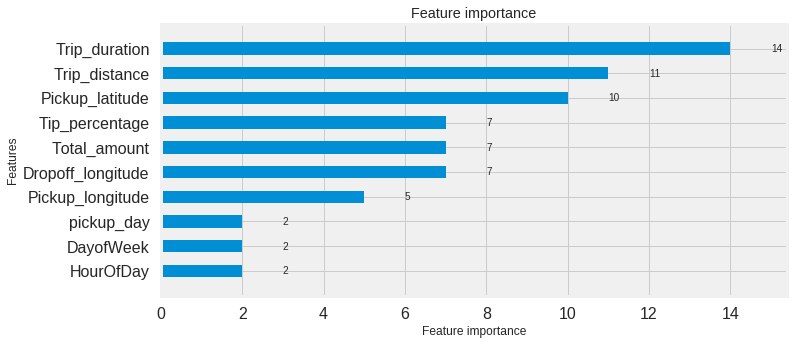

In [196]:
print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=10, height = 0.5)
plt.show()
## correct this later!!!!!!

# Question 5

**Option A: Distributions**



*   Build a derived variable representing the average speed over the course of a trip.
* Can you perform a test to determine if the average trip speeds are materially the same in all weeks of September? If you decide they are not the same, can you form a hypothesis regarding why they differ?
* Can you build up a hypothesis of average trip speed as a function of time of day?




In [198]:
#Avg_speed = Trip_distance/Trip_duration
df['Avg_speed'] = df['Trip_distance']/df['Trip_duration']
df['Avg_speed'].describe()

count    1.484442e+06
mean              inf
std               NaN
min      0.000000e+00
25%      2.592353e-03
50%      3.271719e-03
75%      4.186630e-03
max               inf
Name: Avg_speed, dtype: float64

In [0]:
df['Trip_duration'] =  (df['Lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).astype('timedelta64[s]')
df['Avg_speed'] = df['Trip_distance']/df['Trip_duration']

In [0]:
#There is a 25mph speed limit on NYC taxis and hence can filter out Average speeds from the data that contains speeds more than that.
df= df[df['Avg_speed'] <= 0.00694444] #25 miles per hour

In [206]:
df['Week_of_Month'] = df['lpep_pickup_datetime'].apply(lambda d: (d.day-1) // 7 + 1)
df.groupby('Week_of_Month')['Avg_speed'].mean()

Week_of_Month
1    0.003465
2    0.003252
3    0.003274
4    0.003404
5    0.003201
Name: Avg_speed, dtype: float64

Text(0.5, 0, 'Week of Month')

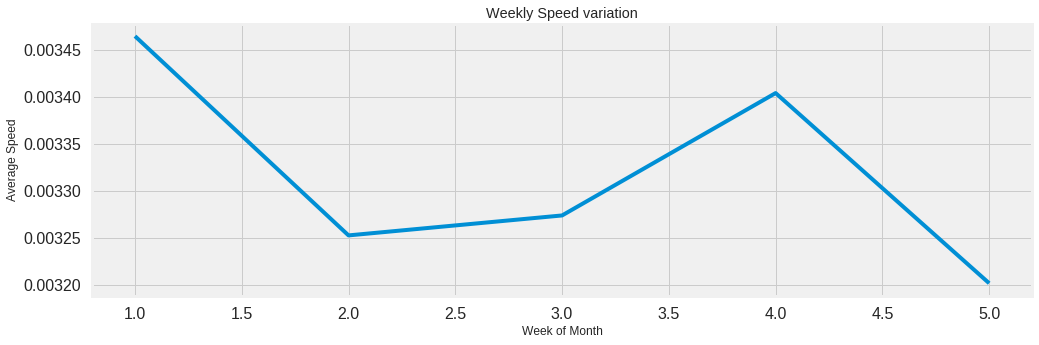

In [208]:
rcParams['figure.figsize'] = 15, 5
df.groupby('Week_of_Month')['Avg_speed'].mean().plot(kind='line')
plt.title('Weekly Speed variation')
plt.ylabel('Average Speed')
plt.xlabel('Week of Month')

Text(0.5, 1.0, 'Boxplot for Weekly speed variation')

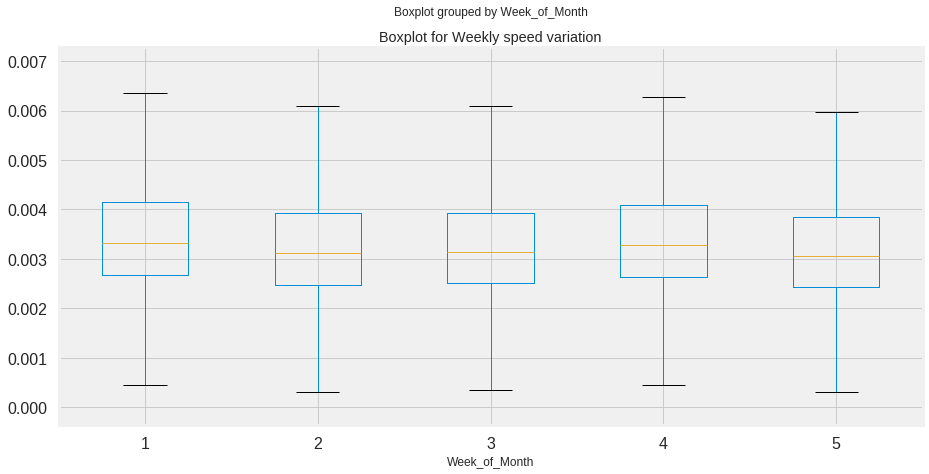

In [209]:
rcParams['figure.figsize'] = 15, 7
df.boxplot('Avg_speed', by='Week_of_Month')
plt.title('Boxplot for Weekly speed variation')


In [213]:
Week0 = df['Avg_speed'][df['Week_of_Month'] == 1]
Week1 = df['Avg_speed'][df['Week_of_Month'] == 2]
Week2 = df['Avg_speed'][df['Week_of_Month'] == 3]
Week3 = df['Avg_speed'][df['Week_of_Month'] == 4]
Week4 = df['Avg_speed'][df['Week_of_Month'] == 5]

Weeks = [Week0,Week1, Week2,Week3,Week4]
headers = ["Week", "F_Statstic", "P_value"]
table =[]

for i in range(len(Weeks)):
    k = i + 1
    while(k <=4):
        Week = "Week_"+str(i+1)+"_"+str(k+1)
        a = Weeks[i]
        b = Weeks[k]
        Fab, pab = stats.f_oneway(a, b)
        table.append([Week,Fab,pab])
        #print(Week, a, b)
        k = k + 1
        
print(tabulate(table, headers, tablefmt="fancy_grid"))

╒══════════╤══════════════╤═════════════╕
│ Week     │   F_Statstic │     P_value │
╞══════════╪══════════════╪═════════════╡
│ Week_1_2 │    4829.07   │ 0           │
├──────────┼──────────────┼─────────────┤
│ Week_1_3 │    3961.73   │ 0           │
├──────────┼──────────────┼─────────────┤
│ Week_1_4 │     378.629  │ 2.61724e-84 │
├──────────┼──────────────┼─────────────┤
│ Week_1_5 │    3070.96   │ 0           │
├──────────┼──────────────┼─────────────┤
│ Week_2_3 │      50.9022 │ 9.71808e-13 │
├──────────┼──────────────┼─────────────┤
│ Week_2_4 │    2455.46   │ 0           │
├──────────┼──────────────┼─────────────┤
│ Week_2_5 │     117.049  │ 2.82348e-27 │
├──────────┼──────────────┼─────────────┤
│ Week_3_4 │    1839.15   │ 0           │
├──────────┼──────────────┼─────────────┤
│ Week_3_5 │     238.966  │ 6.83252e-54 │
├──────────┼──────────────┼─────────────┤
│ Week_4_5 │    1810.38   │ 0           │
╘══════════╧══════════════╧═════════════╛


In [214]:
F, p = stats.f_oneway(Week0,Week1, Week2,Week3,Week4)
print("F statistic", F)
print("p-value", p)

F statistic 1965.6171117954593
p-value 0.0


Text(0, 0.5, 'Traffic of Green cabs')

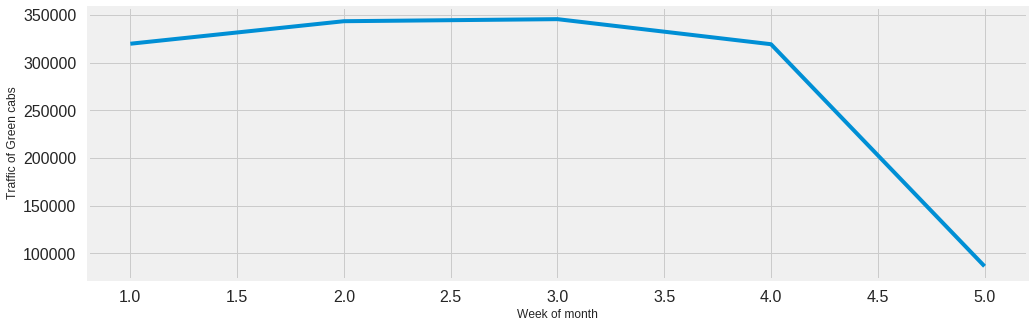

In [215]:
rcParams['figure.figsize'] = 15, 5
df.groupby('Week_of_Month')['Avg_speed'].count().plot()
plt.xlabel('Week of month')
plt.ylabel('Traffic of Green cabs')

In [216]:
GroupedByHOD = df.groupby('HourOfDay')['Avg_speed'].mean().reset_index()
GroupedByHOD

,HourOfDay,Avg_speed
0,0,0.003730
1,1,0.003780
2,2,0.003815
3,3,0.003850
4,4,0.003903
5,5,0.004144
6,6,0.004065
7,7,0.003411
8,8,0.003155
9,9,0.003221


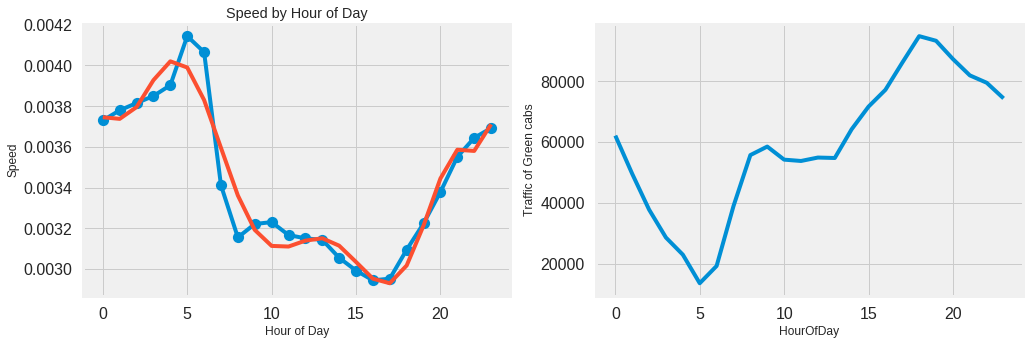

In [217]:
plt.subplot(1,2, 1)
X = GroupedByHOD['HourOfDay']
Y = GroupedByHOD['Avg_speed']

z = np.polyfit(X,Y,9) 
p = np.poly1d(z)

plt.title ('Speed by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Speed')

plt.plot(X, Y,'o-')
plt.plot(X, p(X), '-')

plt.subplot(1,2, 2)
df.groupby('HourOfDay')['Avg_speed'].count().plot()
plt.ylabel('Traffic of Green cabs')
plt.show()


Recommendations to Business/ Green Cab Owners
Based on the above analysis if I had to make recommendations to Green Cab owners to maximize profits, I would suggest the following

Installing a credit card reader in their cabs, since that leads to higher tip percentages.
Operating between 2pm to 6pm in order to maximize the chances of getting a passenger.
Answering Dispatch calls since they lead to higher Trip distances, hence higher profits

The p-value of the ANOVA test is very small and close to 0. Thus, the null hypothesis is rejected - the average trip speeds are not same for all hours.

A 2-sample t-test, with significance value set at 0.05, is performed on all the hours, to check if the means are same between any two hours, the results of p-value is given below:

Hours 8:00 AM and 11:00 AM, 9:00 AM and 10:00 AM have the same mean - p-value is greater than significance value

peak hour traffic would be nearly same, people start leaving for office around 7:00 AM and reach around 11:00 AM causing the average to be approximately same between 8:00 AM and 11:00 AM. Thus, the average speed is same.
Hours 1:00 PM and 7:00 PM, 2:00 PM and 6:00 PM have the same mean - p-value is greater than significance value

mid-day traffic and just after office hours traffic would be nearly same as roads would be cleared from morning rush hour (between 7 to 11 AM and evening rush hour 4-5 PM). Thus, the average speed is same.
Hours 4:00 PM and 5:00 PM have the same mean - p-value is greater than significance value

evening peak hour traffic would be nearly same, people start leaving from office around 4:00 PM causing the average speed to be approximately same
For the remaining combination of hours, p-value is close to 0 and so they don't have the same means.

My hypothesis for average speed variation (based on the boxplot) is below:

average speed is increasing continuously from mid-night, 00:00 AM to 5:00 AM, as majority of the people would be home, and the roads would be empty

average speed dropped at 7:00 AM and continuous nearly the same during the morning peak hours, 7:00 AM to 11:00 AM, as people would be rushing to office

average speed is fluctuating during mid-day, 10:00 AM to 5:00 PM, schools would close, people will be running errands randomly and would start leaving office

average speed is increasing slowly after evening peak hours, 6:00 PM to 11:00 PM, as people would have reached home